In [1]:
# system library
import os

# math and tables
import pandas as pd
import numpy as np

# for model building
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# visualization libraries
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# some utils
from sklearn.model_selection import train_test_split
from random import randint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
# deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import cv2

import warnings
warnings.filterwarnings('ignore')

2025-05-25 16:50:46.770396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748191846.965167      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748191847.026941      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# datasets
labels = pd.read_csv("/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv")
test = pd.read_csv("/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv")
# folders paths
train_path = "/kaggle/input/soil-classification-part-2/soil_competition-2025/train"
test_path = "/kaggle/input/soil-classification-part-2/soil_competition-2025/test"

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Load images
def load_images(df, image_dir):
    images = []
    for img_name in df['image_id']:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(331 , 331))
        img = img_to_array(img) / 255.0 
        images.append(img)
    return np.array(images)

train_images = load_images(labels, train_path)

In [4]:

feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extract features
def extract_features(images):
    return feature_extractor.predict(images)

features = extract_features(train_images)

I0000 00:00:1748191875.418672      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748191875.419362      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1748191885.041745      63 service.cc:148] XLA service 0x79685c24cb90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748191885.042499      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748191885.042517      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748191885.651762      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/39 ━━━━━━━━━━━━━━━━━━━━ 6:37 10s/step

I0000 00:00:1748191892.441394      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 339ms/step


In [5]:
# Reduce to 50 dimensions
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(features)

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

# Assign labels: assume smaller cluster is class 0 (non-soil)
class_0_size = np.sum(clusters == 0)
class_1_size = np.sum(clusters == 1)
corrected_labels = np.where(clusters == (0 if class_0_size < class_1_size else 1), 0, 1)

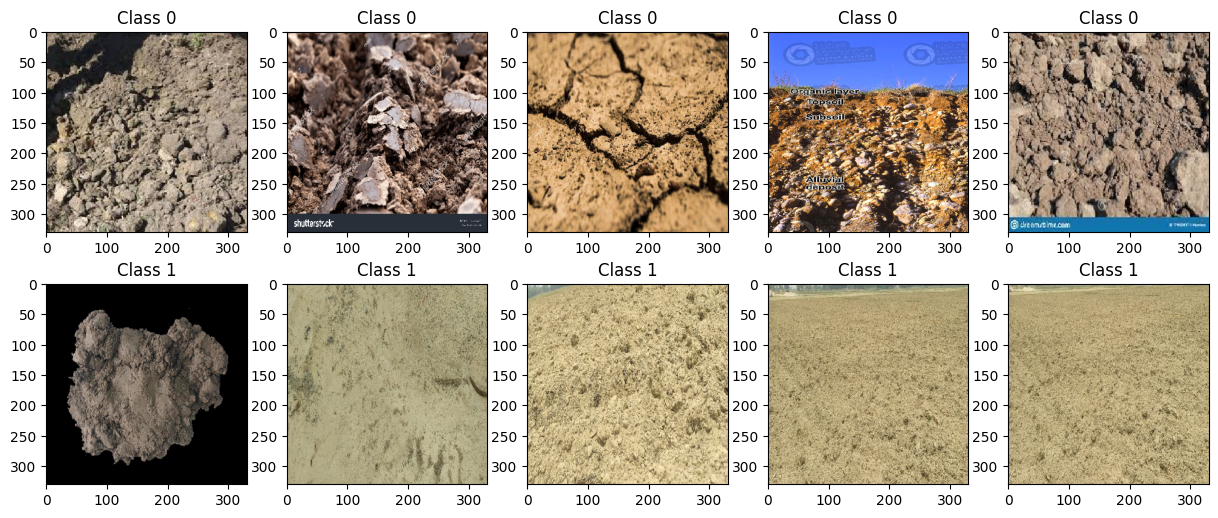

In [6]:
def plot_samples(images, labels, n=5):
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    for i in range(n):
        idx_class0 = np.where(labels == 0)[0][i]
        axes[0,i].imshow(images[idx_class0])
        axes[0,i].set_title("Class 0")
        idx_class1 = np.where(labels == 1)[0][i]
        axes[1,i].imshow(images[idx_class1])
        axes[1,i].set_title("Class 1")
    plt.show()

plot_samples(train_images, corrected_labels)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_images, corrected_labels, test_size=0.2, stratify=corrected_labels
)

In [8]:
from tensorflow.keras import Sequential, layers

model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(331,331,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 329, 329, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 164, 164, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 162, 162, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 81, 81, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 419904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      53,747,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,767,361 (205.11 MB)

 Trainable params: 53,767,361 (205.11 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10


2025-05-25 16:51:56.690572: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,164,164]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,162,162]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-25 16:51:56.913670: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.223272839s
Trying algorithm eng0{} for conv (f32[32,32,164,164]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,162,162]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","con

31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - accuracy: 0.9154 - loss: 4.1592 - val_accuracy: 0.9143 - val_loss: 0.3364
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8880 - loss: 0.3739 - val_accuracy: 0.9143 - val_loss: 0.2521
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9151 - loss: 0.2304 - val_accuracy: 0.9143 - val_loss: 0.1681
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9264 - loss: 0.1728 - val_accuracy: 0.9143 - val_loss: 0.2826
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9048 - loss: 0.2331 - val_accuracy: 0.9143 - val_loss: 0.1073
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9144 - loss: 0.1044 - val_accuracy: 0.9143 - val_loss: 0.0888
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9275 - loss: 0.1028 - val_accuracy: 0.9796 - val_loss: 0.1081
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9864 - loss: 0.0852 - val_accuracy: 0.9714 - val_loss: 

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: \n          0.9825997948646545\nValidation Accuracy: 0.9755101799964905')

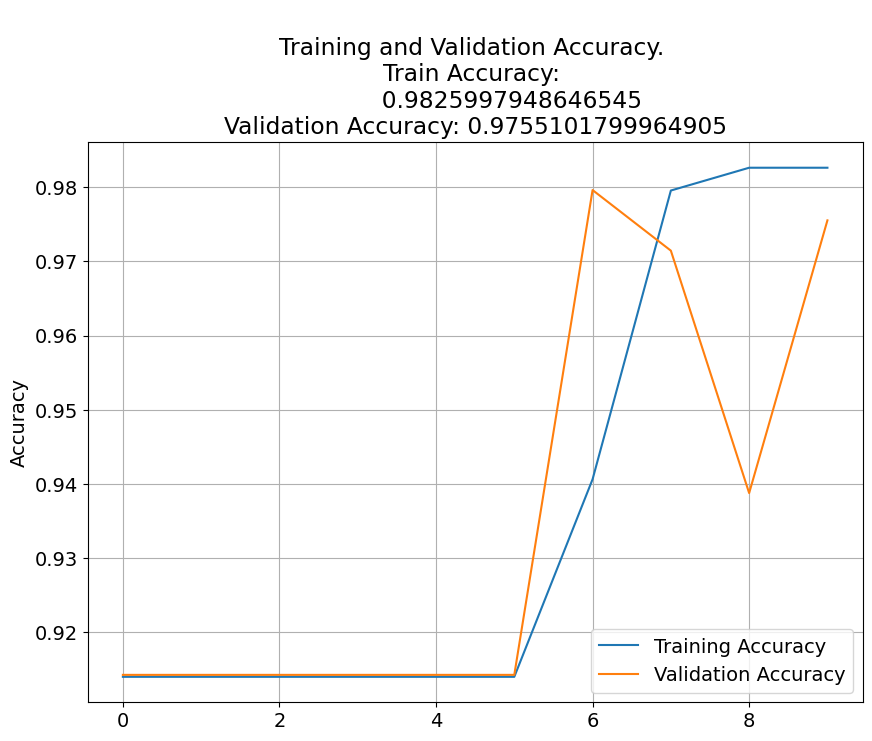

In [13]:
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f"""\nTraining and Validation Accuracy. \nTrain Accuracy: 
          {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}""")

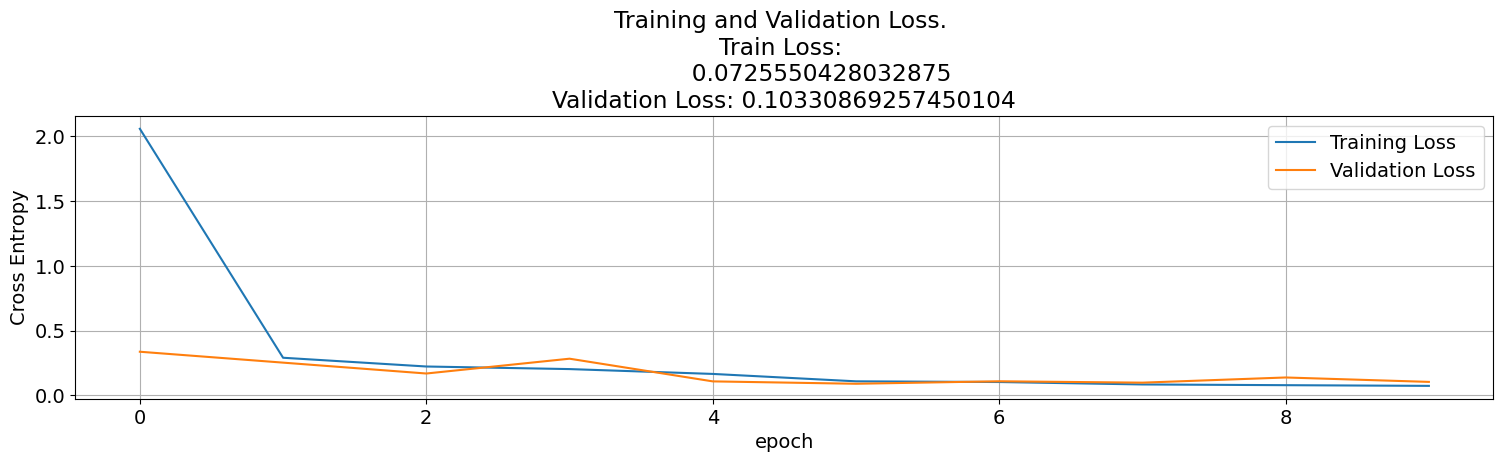

In [14]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f"""Training and Validation Loss. \nTrain Loss: 
          {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}""")
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [15]:
val_probs = val_preds = model.predict(X_val)
val_preds = (val_probs > 0.5).astype(int)  # Threshold at 0.5


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


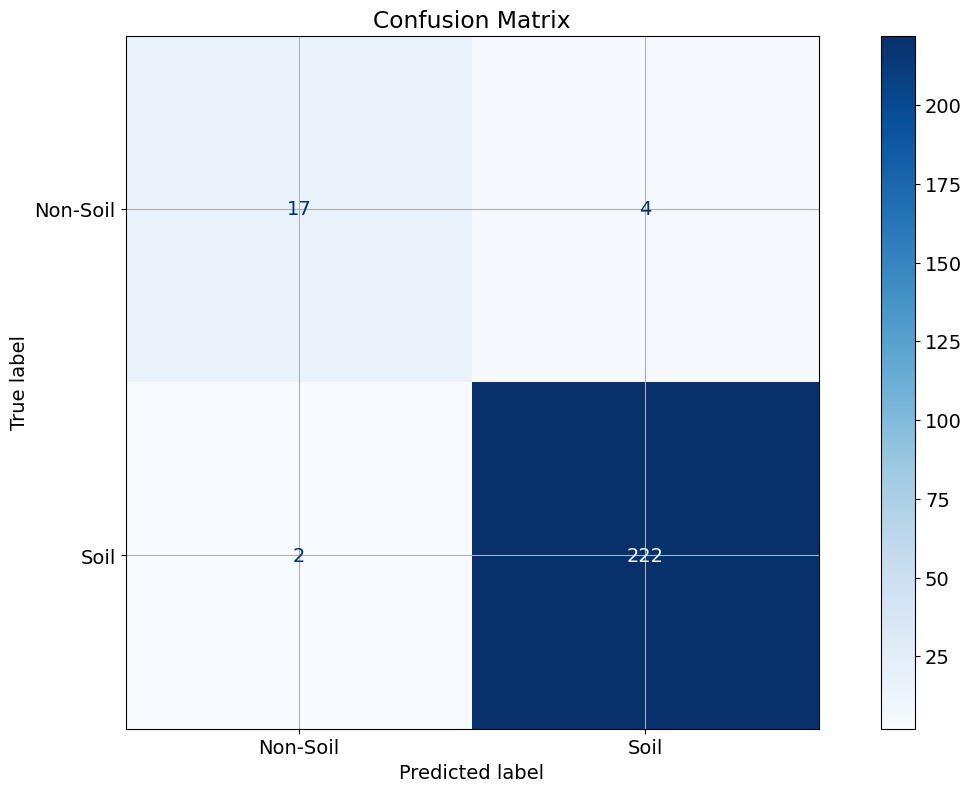

In [16]:
from sklearn.metrics import fbeta_score, classification_report,f1_score,  ConfusionMatrixDisplay
# Assuming you have true test labels (y_test)
val_preds = model.predict(X_val).round().astype(int)
f1 = f1_score(y_val, val_preds)
f2 = fbeta_score(y_val, val_preds, beta=2)  # F-beta with β=2

# Confusion Matrix
cm = confusion_matrix(y_val, val_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Soil", "Soil"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [17]:
# For validation data (from train_test_split)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Validation Accuracy: 0.9755
Validation Loss: 0.1033


In [18]:
test_images = load_images(test, test_path)
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


In [ ]:
submission_df = pd.DataFrame({
    'image_id': test['image_id'],
    'label': predicted_labels
})

submission_df.to_csv('submission.csv', index=False)

NameError: name 'submission_df' is not defined